In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from dask_ml.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
%matplotlib inline

In [3]:
data_dir = os.path.join("..", "work", "feature_data")
filename = os.path.join(data_dir, "training_feature_select_zscore.csv")
df = pd.read_csv(filename, index_col=0)

features = [x for x in df.columns if x.startswith(("actin", "DNA", "dist", "nuclear"))]
y_df = df.loc[:, ["target"]]

x_df = df.loc[:, features]
x_df.head()

,actin.s.area,actin.s.radius.mean,actin.s.radius.sd,actin.s.radius.min,actin.b.sd,actin.b.mad,actin.b.q005,actin.b.q01,actin.b.q05,actin.m.cx,...,DNA.b.mad,DNA.b.q005,DNA.b.q05,DNA.m.cy,DNA.m.majoraxis,DNA.m.eccentricity,DNA.m.theta,dist.10.nn,dist.30.nn,nuclear.displacement
cell_code,,,,,,,,,,,,,,,,,,,,,
OaJHcDs2kh,-0.68658,-0.84463,-0.04209,-1.00999,-0.92994,-1.04017,-0.71324,-0.95855,-1.33273,1.53587,...,-0.58275,-1.44524,-1.51428,1.15905,-0.18347,0.00498,-0.87779,0.39614,0.05683,0.99378
nwLFF4l070,-0.19267,0.03007,0.05701,0.28795,-0.96981,-0.89960,-0.10164,-0.25421,-0.66601,1.41176,...,-0.42717,-1.12844,-1.33824,0.34859,-0.47140,-1.44879,-1.12579,-0.42141,-0.09057,-0.94879
JU4SIplWZ7,-0.54636,-0.66697,-0.87866,-0.01976,-0.49909,-0.62456,-1.31337,-1.08404,-0.47990,-0.10882,...,-0.42717,0.50772,-0.16040,1.22965,-0.65984,-0.18504,0.75104,-0.68024,-0.65167,0.27857
pqkTwaHa2L,-0.65800,-0.78070,-0.33929,-0.72577,-0.03800,0.04774,1.90293,2.16647,1.50849,-0.53638,...,0.85987,0.80976,1.16833,-0.01655,-0.70873,0.11003,0.53794,-0.29376,-0.35578,0.06790
ng7c7qtodJ,0.51649,0.76158,0.31738,1.10353,-0.51431,-0.56345,0.09749,-0.00323,-0.41393,1.08434,...,-0.04530,-0.50566,-0.39932,1.01154,1.86526,1.42241,-1.69087,-0.00756,0.16156,-0.47123


In [4]:
y_df.head()

,target
cell_code,
OaJHcDs2kh,adrenoceptor
nwLFF4l070,adrenoceptor
JU4SIplWZ7,adrenoceptor
pqkTwaHa2L,adrenoceptor
ng7c7qtodJ,adrenoceptor


In [5]:
# hyperparameters to loop over
cs = [0.00001, 0.0001, 0.01, 0.2, 0.5]
penalties = ['l2']

In [6]:
# Build the 5-fold cross validation architecture
clf_parameters = {'classify__C': cs,
                  'classify__penalty': penalties}

estimator = Pipeline(
    steps=[
        ('classify',
         LogisticRegression(random_state=123,
                            class_weight='balanced',
                            multi_class='ovr',
                            max_iter=75,
                            solver='saga')
        )
    ]
)

# Custom scorer that optimizes f1 score weighted by class proportion
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Cross validation pipeline
cv_pipeline = GridSearchCV(estimator=estimator,
                           param_grid=clf_parameters,
                           n_jobs=-1,
                           cv=5,
                           return_train_score=True,
                           scoring=weighted_f1_scorer)

In [7]:
%%time
cv_pipeline.fit(X=x_df, y=y_df.target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

CPU times: user 8min 45s, sys: 24.3 s, total: 9min 9s
Wall time: 1min 25s


GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('classify',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=75,
                                                           multi_class='ovr',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=123,
                      

In [8]:
cv_results = (
    pd.concat([
        pd.DataFrame(cv_pipeline.cv_results_).drop('params', axis=1),
        pd.DataFrame.from_records(cv_pipeline.cv_results_['params'])
    ], axis=1)
)

cv_results.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,...,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,param_classify__C,param_classify__penalty,classify__C,classify__penalty
2,30.425131,4.295432,0.147470,0.028021,0.153797,0.142486,0.161784,0.164414,0.175603,0.159613,...,0.193150,0.182528,0.174890,0.164038,0.178479,0.009524,0.01,l2,0.01000,l2
4,37.311928,1.813140,0.115281,0.052594,0.154216,0.143245,0.158450,0.162541,0.174868,0.158660,...,0.193326,0.185262,0.175271,0.165162,0.179191,0.009528,0.5,l2,0.50000,l2
3,37.081973,2.580356,0.161851,0.069949,0.154203,0.142597,0.158862,0.162239,0.175249,0.158626,...,0.193386,0.185239,0.175550,0.165504,0.179261,0.009436,0.2,l2,0.20000,l2
1,11.258349,1.600153,0.412480,0.297055,0.155547,0.134548,0.155858,0.169184,0.174470,0.157917,...,0.189154,0.176059,0.168611,0.162032,0.173465,0.009068,0.0001,l2,0.00010,l2
0,11.423876,1.156766,0.460873,0.070897,0.153713,0.128936,0.141921,0.160389,0.167497,0.150487,...,0.178667,0.167290,0.159099,0.154393,0.164489,0.008271,1e-05,l2,0.00001,l2


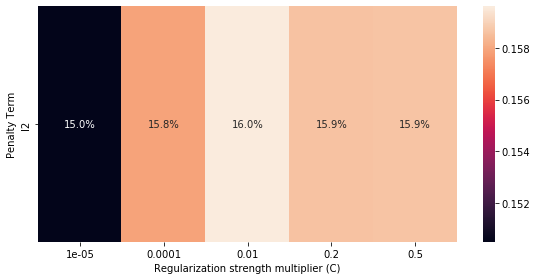

In [9]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results,
                              values='mean_test_score',
                              index='classify__penalty',
                              columns='classify__C')

plt.subplots(figsize=(8,4))
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (C)')
ax.set_ylabel('Penalty Term')
plt.tight_layout()